In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from dataset import Dataset
from tools import getDataset, print_class_distribution

import numpy as np
from sklearn.model_selection import train_test_split

import random

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print("MPS device not found.")
print('Device:', device)

Device: mps


In [3]:
batch_size = 5
num_workers = 4
learning_rate = 0.0001 # 0.00005 - the best one so far
num_epochs = 5
num_classes = 5

root_dir = os.path.join(os.getcwd(), 'datasets/EuroSAT_RGB')
dataset, label_mapping = getDataset(path=root_dir, num_classes=num_classes, num_images_per_class=20, shuffle_images=False)

class_images = {i: [] for i in range(num_classes)}

# Group images by class
for image_path, class_label in dataset:
    class_images[class_label].append((image_path, class_label))

# Initialize training and test sets
train_set = []
test_set = []

# Select 5 images for training and 15 for testing from each class
for class_label, images in class_images.items():
    train_set.extend(random.sample(images, k=5))
    test_set.extend(list(set(images) - set(train_set)))


train_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )

test_transforms = transforms.Compose(
        [
            transforms.RandomCrop(80, padding=8),
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )
    
train_dataset = Dataset(dataset=train_set, path=root_dir, phase='train', transform=train_transforms)
test_dataset = Dataset(dataset=test_set, path=root_dir, phase='test', transform=test_transforms)

Using 20 images per class HerbaceousVegetation
Using 20 images per class Pasture
Using 20 images per class Residential
Using 20 images per class PermanentCrop
Using 20 images per class AnnualCrop


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


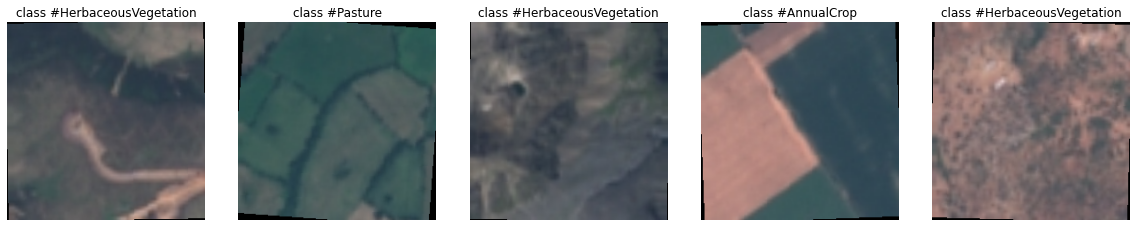

total number of training set: 25
numer of images for class HerbaceousVegetation: 5
numer of images for class Pasture: 5
numer of images for class Residential: 5
numer of images for class PermanentCrop: 5
numer of images for class AnnualCrop: 5


In [6]:
idx = np.random.choice(range(len(train_dataset)), 5, replace=False) # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_dataset[idx[i]]
    print(image.shape)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_mapping[label]))
    ax.axis('off')
    plt.imshow((image).permute(1, 2, 0))

plt.show()

# print number of images for each class
print('total number of training set: {}'.format(len(train_dataset)))

for i in label_mapping.keys():
    print('numer of images for class {}: {}'.format(label_mapping[i], len([label for _, label in train_dataset.data if label == i])))

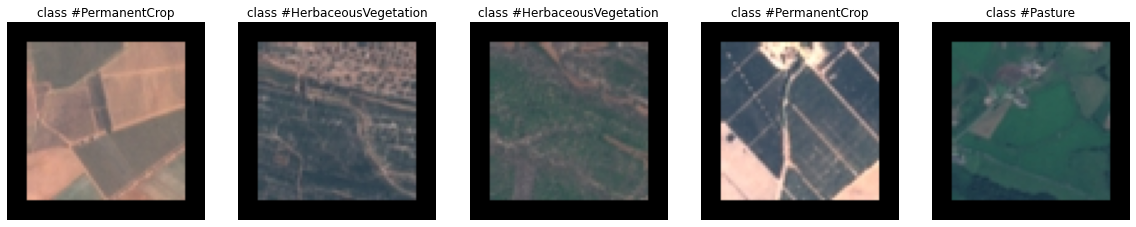

total number of training set: 75
numer of images for class HerbaceousVegetation: 15
numer of images for class Pasture: 15
numer of images for class Residential: 15
numer of images for class PermanentCrop: 15
numer of images for class AnnualCrop: 15


In [5]:
idx = np.random.choice(range(len(test_dataset)), 5, replace=False) # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = test_dataset[idx[i]]
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_mapping[label]))
    ax.axis('off')
    plt.imshow((image).permute(1, 2, 0))

plt.show()

# print number of images for each class
print('total number of training set: {}'.format(len(test_dataset)))

for i in label_mapping.keys():
    print('numer of images for class {}: {}'.format(label_mapping[i], len([label for _, label in test_dataset.data if label == i])))

In [9]:
from models.efficientnet import EfficientNet
import torch
import os

loaded_model = torch.load(os.path.join(os.getcwd(), 'pretrained/efficientnet_model_best_81.04.pth'), map_location=torch.device('cpu'))
model = EfficientNet(num_classes=50).to(torch.device('cpu'))

model.load_state_dict(loaded_model)

<All keys matched successfully>

In [28]:
from models.ViT import ViT
import torch
import os

loaded_model = torch.load(os.path.join(os.getcwd(), 'pretrained/vit_model_best_91.62.pth'), map_location=torch.device('cpu'))
model = ViT(num_classes=50)

# model.load_state_dict(loaded_model)
loaded_model

OrderedDict([('vit.cls_token',
              tensor([[[ 6.5267e-02, -1.3779e-02,  1.2404e-01, -4.6586e-02, -3.7689e-02,
                        -4.6984e-02,  3.3165e-02,  8.6602e-01, -5.9235e-02, -5.0161e-02,
                        -2.7906e-01, -3.2446e-01, -1.9425e+00, -9.3280e-03, -2.8916e-02,
                        -4.1426e-01,  2.5675e-02, -2.6154e-02,  6.2872e-02, -1.5449e-02,
                         2.5884e-02, -7.6649e-03,  1.4103e-01, -1.8023e-02, -7.0501e-02,
                         1.8236e-01, -1.1429e-01, -1.1468e-01, -2.1145e-02,  1.7198e-02,
                        -2.1552e-01, -2.2427e-02, -5.9817e-03, -1.6598e-01, -3.5425e-02,
                        -4.7493e-01, -4.7144e-02,  1.2102e-01, -5.5751e-02, -3.7642e-01,
                         9.5676e-01, -5.4562e-02,  2.1863e-03, -5.3502e-02,  8.2539e-01,
                        -3.3699e-02, -7.5992e-02,  3.6683e-03, -7.2647e-03, -6.7487e-02,
                         6.7713e-03,  3.6611e-03,  1.7631e-02, -7.0526e-02, -2.

In [19]:
import torch
import os
from models.resnet18 import ResNet18

loaded_model = torch.load(os.path.join(os.getcwd(), 'pretrained/resnet_model_best_76.89.pth'), map_location=torch.device('cpu'))
model = ResNet18(num_classes=50)
model.load_state_dict(loaded_model)

<All keys matched successfully>

In [25]:
model

ViT(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=2304, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=2304, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(